In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,MaxAbsScaler
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, Normalizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor,ExtraTreesRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_validate

XỬ LÝ DỮ LIỆU

In [2]:
# Hàm trích xuất giá trị số từ chuỗi
def extract_memory_size(string):
    match = re.search(r'(\d+\.?\d*)\s*(?:TB|GB)', string)
    if match:
        return match.group()
    else:
        return None
# Hàm trích thay đổi giá trị từ TB sang TB    
def convert_to_gb(x):
    if isinstance(x, str):
        x = x.lower()
        if 'tb' in x:
            return int(float(x.replace('tb', '')) * 1024)
        elif 'gb' in x:
            return int(float(x.replace('gb', '')))
    return x
def convert_to_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
def try_convert_to_int(x):
    try:
        return int(x)
    except ValueError:
        return None
def fetch_processor(text):
    text = str(text)
    if 'Core i9' in text or 'Intel Core i9' in text:
        return 'Intel Core i9'
    elif 'Core i7' in text or 'Intel Core i7' in text:
        return 'Intel Core i7'
    elif 'Core i5' in text or 'Intel Core i5' in text:
        return 'Intel Core i5' 
    elif 'Core i3' in text or 'Intel Core i3' in text:
        return 'Intel Core i3'  
    else:
        if text.split()[0] == 'Intel':
            return 'Other Intel Processor'
        elif 'AMD' in text or 'Ryzen' in text:
            return 'AMD Processor'
        elif 'celeron' in text or 'Celeron' in text:
            return 'Celeron Processor'
        elif 'Pentium' in text or 'Pentium' in text:
            return 'Pentium Processor'
        elif 'Athlon' in text or 'athlon' in text:
            return 'Athlon Processor'
        else :
            return None
def fetch_gpu(text):
    text = str(text)
    if 'Intel' in text or 'UHD' in text or  'HD' in text:
        return 'Intel '
    elif 'AMD' in text or 'Radeon' in text:
        return 'AMD'
    elif 'NVIDIA' in text or 'GTX' in text or 'RTX' in text:
        return 'NVIDIA'   
    else:
        return None
def fetch_opsys(text):
    text = str(text)
    if 'Chrome' in text:
        return 'Chrome OS'
    elif 'Windows' in text:
        return 'Windows'  
    else:
        return 'Others/Linux/Mac OS'
def fetch_company(text):
    text = str(text)
    if 'Dell' in text or 'DELL' in text:
        return 'Dell'
    elif 'MSI' in text:
        return 'MSI'
    elif 'HP' in text or 'Hp' in text:
        return 'HP'   
    elif 'Acer' in text or 'ACER' in text:
        return 'Acer'   
    elif 'Razer' in text or 'RAZER' in text:
        return 'Razer'
    elif 'Apple' in text:
        return 'Apple'
    elif 'Lenovo' in text or 'LENOVO' in text:
        return 'Lenovo'
    elif 'ASUS' in text or 'Asus' in text or 'VivoBook' in text:
        return 'Asus'
    else:
        return 'Other'

LÀM SẠCH DỮ LIỆU

In [3]:
def clean_all_data_small(df):
  df = df.applymap(lambda x: x.replace('\u200e', '') if isinstance(x, str) else x)
  df['Inches'] = df['Inches'].str.replace('Inches','')
  df['Inches'] = df['Inches'].apply(convert_to_float)
  df['Screen_Resolution'] = df['Screen_Resolution'].str.replace('Pixels','').str.strip()
  df['RAM'] = df['RAM'].str.extract('(\d+)')
  df['RAM'] = df['RAM'].astype(float).fillna(0).astype(int)
  df['Weights'] = df['Weights'].str.replace('pounds', '').str.replace('ounces', '').str.strip()
  df['Weights'] = df['Weights'].astype(float)
  df['Memory'] = df['Memory'].astype(str).replace('\.0', '', regex=True)
  df['Memory'] = df['Memory'].replace(["HDD", "SSD","Emmc","Flash Storage","Solid State Hard Drive","MB","flash_memory_solid_state","Serial ATA-600","Embedded MultiMediaCard"], '')
  df.loc[df['Memory'].str.contains('256GB PCIe M.2 SSD \+ 1TB \(\+8GB SSHD\) Hybrid Drive'), 'Memory'] = '1256GB'
  df['Memory'] = df['Memory'].apply(extract_memory_size)
  df['Memory'] = df['Memory'].apply(convert_to_gb)
  df['OpSys'] = df['OpSys'].apply(fetch_opsys)
  df['Price'] = df['Price'].str.replace(',', '')
  df['Price'] = df['Price'].str.replace('$', '').str.replace('From', '').replace(',', '.').str.strip()
  df['Price'].replace('Unavailable', np.nan, inplace=True)
  df['Price'] = df['Price'].astype(float)
  df['Company'] = df['Company'].apply(fetch_company)
  return df

def clean_all_data_big(df):
  df = df.applymap(lambda x: x.replace('\u200e', '') if isinstance(x, str) else x)
  df_big['Inches'] = df_big['Inches'].str.replace('1 Centimeters','1')
  df_big['Inches'] = df_big['Inches'].str.replace('15.6 Feet','15.6')
  df['Inches'] = df['Inches'].apply(convert_to_float)
  df['RAM'] = df['RAM'].astype(float).fillna(0).astype(int)
  df['Weights'] = df['Weights'].astype(float)
  df['Memory'] = df['Memory'].astype(str).replace('\.0', '', regex=True)
  df['Memory'] = df['Memory'].replace(["HDD", "SSD","Emmc","Flash Storage","Solid State Hard Drive","MB","flash_memory_solid_state","Serial ATA-600","Embedded MultiMediaCard"], '')
  df.loc[df['Memory'].str.contains('256GB PCIe M.2 SSD \+ 1TB \(\+8GB SSHD\) Hybrid Drive'), 'Memory'] = '1256GB'
  df['Memory'] = df['Memory'].apply(extract_memory_size)
  df['Memory'] = df['Memory'].apply(convert_to_gb)
  df['OpSys'] = df['OpSys'].apply(fetch_opsys)
  df['Company'] = df['Company'].apply(fetch_company)
  return df

TẠO ĐẶC TRƯNG MỚI

In [4]:
def create_new_feature(df):  
  df['X_res'] = df['Screen_Resolution'].str.split('[xX*]').str[0].str.strip()
  df['Y_res'] = df['Screen_Resolution'].str.split('[xX*]').str[1].str.strip()
  df['X_res'] = df['X_res'].apply(try_convert_to_int)
  df['Y_res'] = df['Y_res'].apply(try_convert_to_int)
  df.drop(columns=['Screen_Resolution'],inplace=True)
  df['Gaming'] = df['Name'].str.contains('Alienware|Gaming|Predator|ROG|MSI', case=False).astype(int)
  df['Touchscreen'] = df['Name'].str.contains('Touchscreen', case=False).astype(int)
  df.drop(columns=['Name'],inplace=True)
  
  return df

# hàm này có xử lý thêm CPU Brand và Gpu brand để phục vụ cho kỹ thuật Label Encoding
def create_new_feature_1(df):  
  df['X_res'] = df['Screen_Resolution'].str.split('[xX*]').str[0].str.strip()
  df['Y_res'] = df['Screen_Resolution'].str.split('[xX*]').str[1].str.strip()
  df['X_res'] = df['X_res'].apply(try_convert_to_int)
  df['Y_res'] = df['Y_res'].apply(try_convert_to_int)
  df.drop(columns=['Screen_Resolution'],inplace=True)
  df['Cpu Brand'] = df['CPU'].apply(fetch_processor)
  df.drop(columns=['CPU'],inplace=True)
  df['Gpu brand'] = df['GPU'].apply(fetch_gpu)
  df.drop(columns=['GPU'],inplace=True)
  df['Gaming'] = df['Name'].str.contains('Alienware|Gaming|Predator|ROG|MSI', case=False).astype(int)
  df['Touchscreen'] = df['Name'].str.contains('Touchscreen', case=False).astype(int)
  df.drop(columns=['Name'],inplace=True)
  return df

def create_feature_ppi(df): 
  df['ppi'] = (((df['X_res']**2) + (df['Y_res']**2))**0.5/df['Inches']).astype('float')
  return df

XỬ LÍ DỮ LIỆU TRỐNG

In [5]:
def Impute_missing_value(df,impute_method,df_train = None):
    if df_train is None:
        if impute_method == 'mean':
            df = df.fillna(df.mean())
        elif impute_method == 'mode':
            df= df.fillna(df.mode()[0])
        elif impute_method == 'median':
            df = df.fillna(df.median())
    else:
        if impute_method == 'mean':
            df = df.fillna(df_train.mean())
        elif impute_method == 'mode':
            df = df.fillna(df_train.mode()[0])
        elif impute_method == 'median':
            df = df.fillna(df_train.median())
    return df

Đọc tập dữ liệu từ file và chia làm train set, test set, validation set

In [43]:
df_big = pd.read_csv('./raw data/10000_data.csv')
df_big = clean_all_data_big(df_big)

In [44]:
df_small = pd.read_csv('./raw data/1000_sampled_data.csv')
df_small = clean_all_data_small(df_small)
df_small['Price'] = Impute_missing_value(df_small['Price'],'mean')

In [45]:
from sklearn.model_selection import train_test_split
X_small = df_small.drop(columns=['Price'])
y_small = np.log(df_small['Price'])
X_train_s,X_test_s,y_train_s,y_test_s = train_test_split(X_small,y_small,test_size=0.3, random_state = 2)
X_test_s, X_val_s, y_test_s, y_val_s = train_test_split(X_test_s, y_test_s, test_size=0.5, random_state=2)

In [46]:
X_big = df_big.drop(columns=['Price'])
y_big = np.log(df_big['Price'])
X_train_b,X_test_b,y_train_b,y_test_b = train_test_split(X_big,y_big,test_size=0.3,random_state=2)
X_test_b, X_val_b, y_test_b, y_val_b = train_test_split(X_test_b, y_test_b, test_size=0.5, random_state=2)

In [84]:
X_big.sample(10)

,Company,Name,Inches,Screen_Resolution,CPU,RAM,Memory,GPU,OpSys,Weights
4343,Dell,"Dell Latitude 5480 14in Notebook, Full-HD Touc...",14.0,NaN,Intel Atom,16,256.0,Intel HD Graphics 520,Windows,3.53
2541,MSI,"MSI Creator 17 Professional Laptop: 17.3"" UHD ...",17.3,3840 x 2160,Core i7 Family,16,512.0,NVIDIA GeForce RTX 3060,Windows,5.40
5501,Asus,"ASUS ZenBook 14X OLED Space Edition Laptop, 14...",14.0,2880 x 1800,Core i9,32,NaN,Intel Iris,Windows,9.60
3662,MSI,"MSI Creator Z17 17"" Professional Creator Lapto...",17.0,2560 x 1600,Core i9,32,2048.0,NVIDIA GeForce RTX 3080,Windows,7.93
342,Acer,Acer Chromebook Spin 314 Convertible Laptop | ...,14.0,1366x768,Pentium,8,128.0,Intel UHD Graphics,Chrome OS,3.42
3196,Dell,"Dell Latitude 5000 5430 14"" Notebook - Full HD...",14.0,1920 x 1080,Core i7,8,256.0,Intel Iris Xe Graphics,Windows,5.40
6135,Acer,"Acer - Nitro 5 15.6"" Laptop - Intel Core i5 --...",15.6,1920 x 1080,Corei5-10300H,8,256.0,NVIDIA GeForce GTX 1650,Windows,5.06
960,Asus,"ASUS Chromebook C424, 14.0"" 180 Degree FHD Nan...",14.0,1920x1080,Celeron N4020,4,128.0,Intel UHD Graphics 600,Chrome OS,5.16
4824,HP,"HP - Pavilion x360 2-in-1 14"" Touch-Screen Lap...",14.0,1920x1080,Intel Core i5,8,512.0,Intel Iris,Windows,4.75
1022,HP,HP 2022 High Performance Business Laptop - 17....,17.3,1600 x 900,Core i7 Family,16,1024.0,Intel Iris Xe Graphics,Windows,4.60


Clean data cho X_big, X_small để dùng cho cross validate trên toàn bộ tập dữ liệu

In [85]:
X_big = create_new_feature_1(X_big)
X_small = create_new_feature_1(X_small)

In [86]:
X_big['X_res'] = Impute_missing_value(X_big['X_res'], 'mean')
X_big['Y_res'] = Impute_missing_value(X_big['Y_res'], 'mean')
X_big['Memory'] = Impute_missing_value(X_big['Memory'], 'mean')
X_big['Inches'] = Impute_missing_value(X_big['Inches'], 'mean')
X_big['RAM'] = X_big['RAM'].replace(0, X_big['RAM'].mean())
X_big['Weights'] = Impute_missing_value(X_big['Weights'], 'mean')
X_big['Cpu Brand'] = Impute_missing_value(X_big['Cpu Brand'], 'mode')
X_big['Gpu brand'] = Impute_missing_value(X_big['Gpu brand'], 'mode')
X_big['OpSys'] = Impute_missing_value(X_big['OpSys'], 'mode')

In [87]:
X_small['X_res'] = Impute_missing_value(X_small['X_res'], 'mean')
X_small['Y_res'] = Impute_missing_value(X_small['Y_res'], 'mean')
X_small['Memory'] = Impute_missing_value(X_small['Memory'], 'mean')
X_small['Inches'] = Impute_missing_value(X_small['Inches'], 'mean')
X_small['RAM'] = X_small['RAM'].replace(0, X_small['RAM'].mean())
X_small['Weights'] = Impute_missing_value(X_small['Weights'], 'mean')
X_small['Cpu Brand'] = Impute_missing_value(X_small['Cpu Brand'], 'mode')
X_small['Gpu brand'] = Impute_missing_value(X_small['Gpu brand'], 'mode')
X_small['OpSys'] = Impute_missing_value(X_small['OpSys'], 'mode')

In [88]:
X_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      1000 non-null   object 
 1   Inches       1000 non-null   float64
 2   RAM          1000 non-null   float64
 3   Memory       1000 non-null   float64
 4   OpSys        1000 non-null   object 
 5   Weights      1000 non-null   float64
 6   X_res        1000 non-null   float64
 7   Y_res        1000 non-null   float64
 8   Cpu Brand    1000 non-null   object 
 9   Gpu brand    1000 non-null   object 
 10  Gaming       1000 non-null   int32  
 11  Touchscreen  1000 non-null   int32  
dtypes: float64(6), int32(2), object(4)
memory usage: 86.1+ KB


In [89]:
X_small = create_feature_ppi(X_small)
X_big = create_feature_ppi(X_big)

In [90]:
X_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10305 entries, 0 to 10304
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      10305 non-null  object 
 1   Inches       10305 non-null  float64
 2   RAM          10305 non-null  float64
 3   Memory       10305 non-null  float64
 4   OpSys        10305 non-null  object 
 5   Weights      10305 non-null  float64
 6   X_res        10305 non-null  float64
 7   Y_res        10305 non-null  float64
 8   Cpu Brand    10305 non-null  object 
 9   Gpu brand    10305 non-null  object 
 10  Gaming       10305 non-null  int32  
 11  Touchscreen  10305 non-null  int32  
 12  ppi          10305 non-null  float64
dtypes: float64(7), int32(2), object(4)
memory usage: 966.2+ KB


In [91]:
le = LabelEncoder()
X_big['Company'] = le.fit_transform(X_big['Company'])
X_big['OpSys'] = le.fit_transform(X_big['OpSys'])
X_big['Cpu Brand'] = le.fit_transform(X_big['Cpu Brand'])
X_big['Gpu brand'] = le.fit_transform(X_big['Gpu brand'])

In [92]:
X_small['Company'] = le.fit_transform(X_small['Company'])
X_small['OpSys'] = le.fit_transform(X_small['OpSys'])
X_small['Cpu Brand'] = le.fit_transform(X_small['Cpu Brand'])
X_small['Gpu brand'] = le.fit_transform(X_small['Gpu brand'])

In [93]:
X_small.sample(10)

,Company,Inches,RAM,Memory,OpSys,Weights,X_res,Y_res,Cpu Brand,Gpu brand,Gaming,Touchscreen,ppi
106,0,17.3,16.0,1024.000000,2,6.83,2560.000000,1440.000000,0,2,1,0,169.780899
980,3,14.0,16.0,512.000000,2,4.34,1920.000000,1080.000000,4,1,0,0,157.350512
306,4,14.0,4.0,640.953984,2,3.96,1939.714451,1114.262967,5,1,0,0,159.784199
170,6,15.6,16.0,512.000000,2,4.96,1920.000000,1080.000000,5,2,1,0,141.211998
277,3,15.6,32.0,512.000000,2,4.48,1939.714451,1114.262967,5,1,0,0,143.396076
114,0,11.0,4.0,640.953984,0,1.00,1366.000000,768.000000,5,1,0,0,142.462986
59,5,14.0,8.0,128.000000,2,4.54,1939.714451,1114.262967,3,1,0,0,159.784199
648,3,14.0,32.0,2048.000000,2,6.00,1920.000000,1080.000000,4,1,0,0,157.350512
138,3,15.6,16.0,1024.000000,2,7.07,1920.000000,1114.262967,5,2,1,0,142.301657
414,4,15.6,4.0,750.000000,2,4.90,1366.000000,768.000000,8,1,0,0,100.454670


In [94]:
X_train_b = create_new_feature_1(X_train_b)
X_train_s = create_new_feature_1(X_train_s)
X_test_s = create_new_feature_1(X_test_s)
X_test_b = create_new_feature_1(X_test_b)
X_val_s = create_new_feature_1(X_val_s)
X_val_b = create_new_feature_1(X_val_b)

In [95]:
X_train_s['X_res'] = Impute_missing_value(X_train_s['X_res'], 'mean')
X_train_s['Y_res'] = Impute_missing_value(X_train_s['Y_res'], 'mean')
X_train_s['Memory'] = Impute_missing_value(X_train_s['Memory'], 'mean')
X_train_s['Inches'] = Impute_missing_value(X_train_s['Inches'], 'mean')
X_train_s['RAM'] = X_train_s['RAM'].replace(0, X_train_s['RAM'].mean())
X_train_s['Weights'] = Impute_missing_value(X_train_s['Weights'], 'mean')
X_train_s['Cpu Brand'] = Impute_missing_value(X_train_s['Cpu Brand'], 'mode')
X_train_s['Gpu brand'] = Impute_missing_value(X_train_s['Gpu brand'], 'mode')
X_train_s['OpSys'] = Impute_missing_value(X_train_s['OpSys'], 'mode')

X_train_b['X_res'] = Impute_missing_value(X_train_b['X_res'], 'mean')
X_train_b['Y_res'] = Impute_missing_value(X_train_b['Y_res'], 'mean')
X_train_b['Memory'] = Impute_missing_value(X_train_b['Memory'], 'mean')
X_train_b['Inches'] = Impute_missing_value(X_train_b['Inches'], 'mean')
X_train_b['RAM'] = X_train_b['RAM'].replace(0, X_train_b['RAM'].mean())
X_train_b['Weights'] = Impute_missing_value(X_train_b['Weights'], 'mean')
X_train_b['Cpu Brand'] = Impute_missing_value(X_train_b['Cpu Brand'], 'mode')
X_train_b['Gpu brand'] = Impute_missing_value(X_train_b['Gpu brand'], 'mode')
X_train_b['OpSys'] = Impute_missing_value(X_train_b['OpSys'], 'mode')


X_test_s['X_res'] = Impute_missing_value(X_test_s['X_res'], 'mean',X_train_s['X_res'])
X_test_s['Y_res'] = Impute_missing_value(X_test_s['Y_res'], 'mean',X_train_s['Y_res'])
X_test_s['Memory'] = Impute_missing_value(X_test_s['Memory'], 'mean',X_train_s['Memory'])
X_test_s['Inches'] = Impute_missing_value(X_test_s['Inches'], 'mean', X_train_s['Inches'])
X_test_s['RAM'] = X_test_s['RAM'].replace(0, X_train_s['RAM'].mean())
X_test_s['Weights'] = Impute_missing_value(X_test_s['Weights'], 'mean',X_train_s['Weights'])
X_test_s['Cpu Brand'] = Impute_missing_value(X_test_s['Cpu Brand'], 'mode',X_train_s['Cpu Brand'])
X_test_s['Gpu brand'] = Impute_missing_value(X_test_s['Gpu brand'], 'mode',X_train_s['Gpu brand'])
X_test_s['OpSys'] = Impute_missing_value(X_test_s['OpSys'], 'mode',X_train_s['OpSys'])

X_test_b['X_res'] = Impute_missing_value(X_test_b['X_res'], 'mean',X_train_b['X_res'])
X_test_b['Y_res'] = Impute_missing_value(X_test_b['Y_res'], 'mean',X_train_b['Y_res'])
X_test_b['Memory'] = Impute_missing_value(X_test_b['Memory'], 'mean',X_train_b['Memory'])
X_test_b['Inches'] = Impute_missing_value(X_test_b['Inches'], 'mean', X_train_b['Inches'])
X_test_b['RAM'] = X_test_b['RAM'].replace(0, X_train_b['RAM'].mean())
X_test_b['Weights'] = Impute_missing_value(X_test_b['Weights'], 'mean',X_train_b['Weights'])
X_test_b['Cpu Brand'] = Impute_missing_value(X_test_b['Cpu Brand'], 'mode',X_train_b['Cpu Brand'])
X_test_b['Gpu brand'] = Impute_missing_value(X_test_b['Gpu brand'], 'mode',X_train_b['Gpu brand'])
X_test_b['OpSys'] = Impute_missing_value(X_test_b['OpSys'], 'mode',X_train_b['OpSys'])


X_val_s['X_res'] = Impute_missing_value(X_val_s['X_res'], 'mean',X_train_s['X_res'])
X_val_s['Y_res'] = Impute_missing_value(X_val_s['Y_res'], 'mean',X_train_s['Y_res'])
X_val_s['Memory'] = Impute_missing_value(X_val_s['Memory'], 'mean',X_train_s['Memory'])
X_val_s['Inches'] = Impute_missing_value(X_val_s['Inches'], 'mean', X_train_s['Inches'])
X_val_s['RAM'] = X_val_s['RAM'].replace(0, X_train_s['RAM'].mean())
X_val_s['Weights'] = Impute_missing_value(X_val_s['Weights'], 'mean',X_train_s['Weights'])
X_val_s['Cpu Brand'] = Impute_missing_value(X_val_s['Cpu Brand'], 'mode',X_train_s['Cpu Brand'])
X_val_s['Gpu brand'] = Impute_missing_value(X_val_s['Gpu brand'], 'mode',X_train_s['Gpu brand'])
X_val_s['OpSys'] = Impute_missing_value(X_val_s['OpSys'], 'mode',X_train_s['OpSys'])

X_val_b['X_res'] = Impute_missing_value(X_val_b['X_res'], 'mean',X_train_b['X_res'])
X_val_b['Y_res'] = Impute_missing_value(X_val_b['Y_res'], 'mean',X_train_b['Y_res'])
X_val_b['Memory'] = Impute_missing_value(X_val_b['Memory'], 'mean',X_train_b['Memory'])
X_val_b['Inches'] = Impute_missing_value(X_val_b['Inches'], 'mean', X_train_b['Inches'])
X_val_b['RAM'] = X_val_b['RAM'].replace(0, X_train_b['RAM'].mean())
X_val_b['Weights'] = Impute_missing_value(X_val_b['Weights'], 'mean',X_train_b['Weights'])
X_val_b['Cpu Brand'] = Impute_missing_value(X_val_b['Cpu Brand'], 'mode',X_train_b['Cpu Brand'])
X_val_b['Gpu brand'] = Impute_missing_value(X_val_b['Gpu brand'], 'mode',X_train_b['Gpu brand'])
X_val_b['OpSys'] = Impute_missing_value(X_val_b['OpSys'], 'mode',X_train_b['OpSys'])

In [96]:
X_train_s = create_feature_ppi(X_train_s)
X_train_b = create_feature_ppi(X_train_b)
X_test_s = create_feature_ppi(X_test_s)
X_test_b = create_feature_ppi(X_test_b)
X_val_s = create_feature_ppi(X_val_s)
X_val_b = create_feature_ppi(X_val_b)

In [97]:
X_train_s['Company'] = le.fit_transform(X_train_s['Company'])
X_train_s['OpSys'] = le.fit_transform(X_train_s['OpSys'])
X_train_s['Cpu Brand'] = le.fit_transform(X_train_s['Cpu Brand'])
X_train_s['Gpu brand'] = le.fit_transform(X_train_s['Gpu brand'])

X_train_b['Company'] = le.fit_transform(X_train_b['Company'])
X_train_b['OpSys'] = le.fit_transform(X_train_b['OpSys'])
X_train_b['Cpu Brand'] = le.fit_transform(X_train_b['Cpu Brand'])
X_train_b['Gpu brand'] = le.fit_transform(X_train_b['Gpu brand'])

X_test_s['Company'] = le.fit_transform(X_test_s['Company'])
X_test_s['OpSys'] = le.fit_transform(X_test_s['OpSys'])
X_test_s['Cpu Brand'] = le.fit_transform(X_test_s['Cpu Brand'])
X_test_s['Gpu brand'] = le.fit_transform(X_test_s['Gpu brand'])

X_test_b['Company'] = le.fit_transform(X_test_b['Company'])
X_test_b['OpSys'] = le.fit_transform(X_test_b['OpSys'])
X_test_b['Cpu Brand'] = le.fit_transform(X_test_b['Cpu Brand'])
X_test_b['Gpu brand'] = le.fit_transform(X_test_b['Gpu brand'])

X_val_s['Company'] = le.fit_transform(X_val_s['Company'])
X_val_s['OpSys'] = le.fit_transform(X_val_s['OpSys'])
X_val_s['Cpu Brand'] = le.fit_transform(X_val_s['Cpu Brand'])
X_val_s['Gpu brand'] = le.fit_transform(X_val_s['Gpu brand'])

X_val_b['Company'] = le.fit_transform(X_val_b['Company'])
X_val_b['OpSys'] = le.fit_transform(X_val_b['OpSys'])
X_val_b['Cpu Brand'] = le.fit_transform(X_val_b['Cpu Brand'])
X_val_b['Gpu brand'] = le.fit_transform(X_val_b['Gpu brand'])

In [98]:
X_train_b.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7213 entries, 7680 to 7336
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      7213 non-null   int32  
 1   Inches       7213 non-null   float64
 2   RAM          7213 non-null   float64
 3   Memory       7213 non-null   float64
 4   OpSys        7213 non-null   int32  
 5   Weights      7213 non-null   float64
 6   X_res        7213 non-null   float64
 7   Y_res        7213 non-null   float64
 8   Cpu Brand    7213 non-null   int32  
 9   Gpu brand    7213 non-null   int32  
 10  Gaming       7213 non-null   int32  
 11  Touchscreen  7213 non-null   int32  
 12  ppi          7213 non-null   float64
dtypes: float64(7), int32(6)
memory usage: 619.9 KB


#### Lựa chọn đặc trưng quan trọng

Thử với thuật toán RandomForest trên tập small

In [99]:
rf = RandomForestRegressor(random_state=3)

rf.fit(X_train_s, y_train_s)

feature_importances1 = pd.DataFrame(rf.feature_importances_, index=X_train_s.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances1)

top_features1 = feature_importances1.index[:6].tolist()
print(top_features1)

             importance
RAM            0.477628
Weights        0.136525
Memory         0.076417
Company        0.051409
Cpu Brand      0.051075
ppi            0.049733
X_res          0.034231
Y_res          0.033656
Inches         0.031095
OpSys          0.022466
Gpu brand      0.019498
Touchscreen    0.013456
Gaming         0.002811
['RAM', 'Weights', 'Memory', 'Company', 'Cpu Brand', 'ppi']


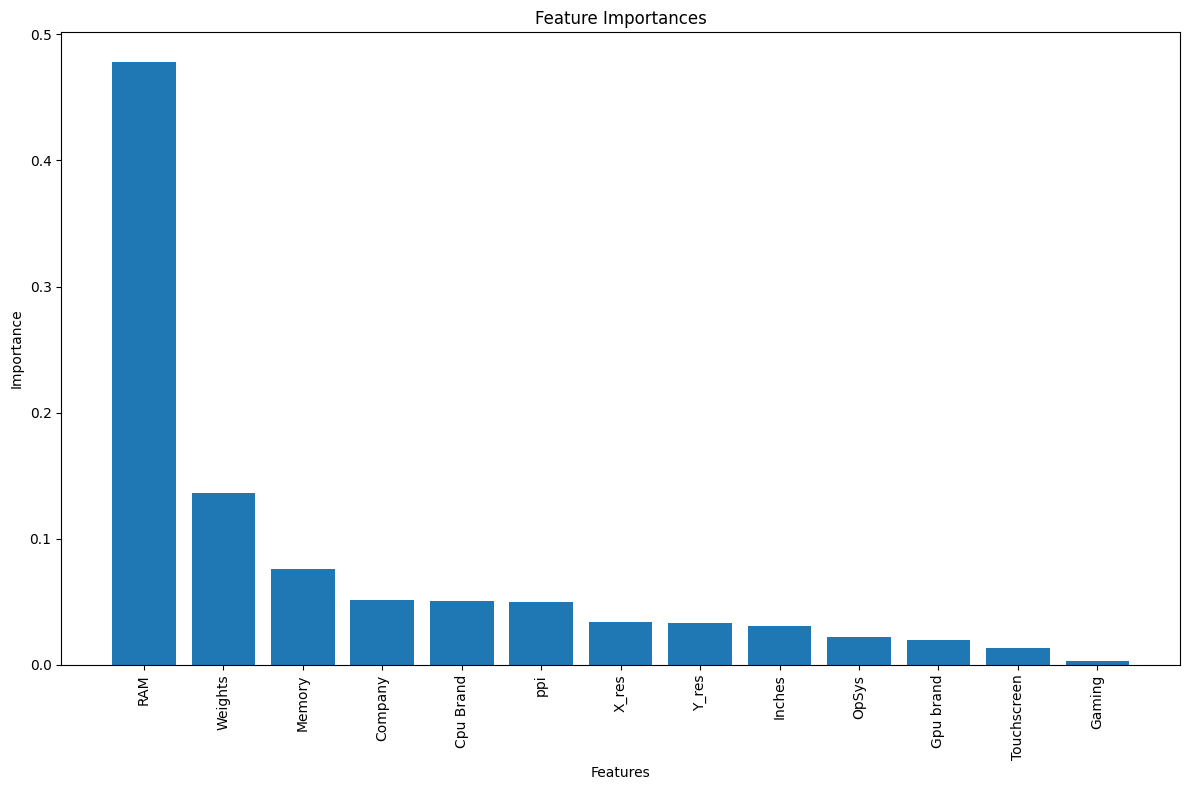

In [100]:
plt.figure(figsize=(12, 8))
plt.bar(feature_importances1.index, feature_importances1['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Thử với thuật toán RandomForest trên tập big

In [101]:

rf = RandomForestRegressor(random_state=3)

rf.fit(X_train_b, y_train_b)

feature_importances2 = pd.DataFrame(rf.feature_importances_, index=X_train_b.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances2)

top_features2 = feature_importances2.index[:6].tolist()
print(top_features2)

             importance
RAM            0.343881
Memory         0.184415
Weights        0.124817
Cpu Brand      0.078834
Y_res          0.059842
Company        0.050189
ppi            0.038816
Inches         0.035148
Gpu brand      0.026996
X_res          0.024027
Touchscreen    0.014474
OpSys          0.013368
Gaming         0.005193
['RAM', 'Memory', 'Weights', 'Cpu Brand', 'Y_res', 'Company']


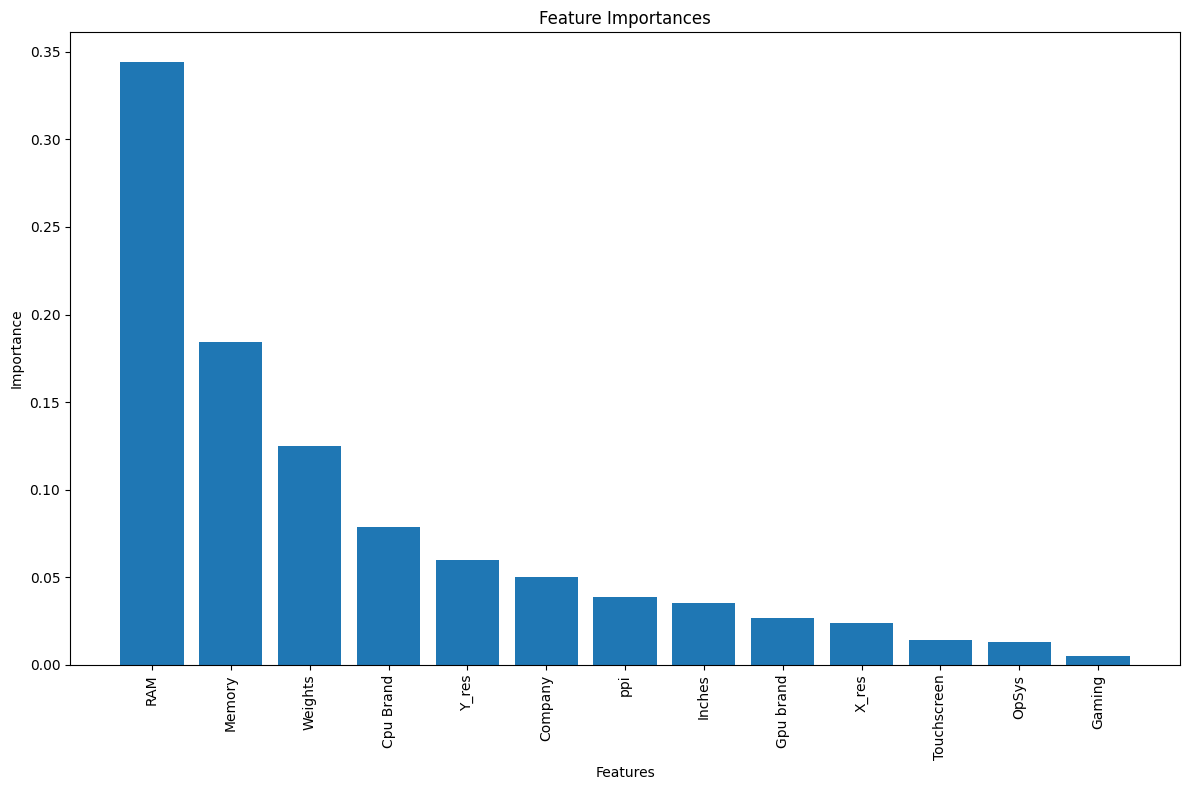

In [102]:
plt.figure(figsize=(12, 8))
plt.bar(feature_importances2.index, feature_importances2['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Thử với thuật toán GradientBoosting trên tập small

In [103]:
rf = GradientBoostingRegressor(random_state=3)

rf.fit(X_train_s, y_train_s)

feature_importances3 = pd.DataFrame(rf.feature_importances_, index=X_train_s.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances3)

top_features3 = feature_importances3.index[:6].tolist()
print(top_features3)

             importance
RAM            0.563526
Weights        0.096834
Memory         0.071609
X_res          0.059240
Cpu Brand      0.039341
Y_res          0.034847
Gpu brand      0.030271
ppi            0.029859
Inches         0.023445
OpSys          0.023151
Company        0.019159
Touchscreen    0.008587
Gaming         0.000132
['RAM', 'Weights', 'Memory', 'X_res', 'Cpu Brand', 'Y_res']


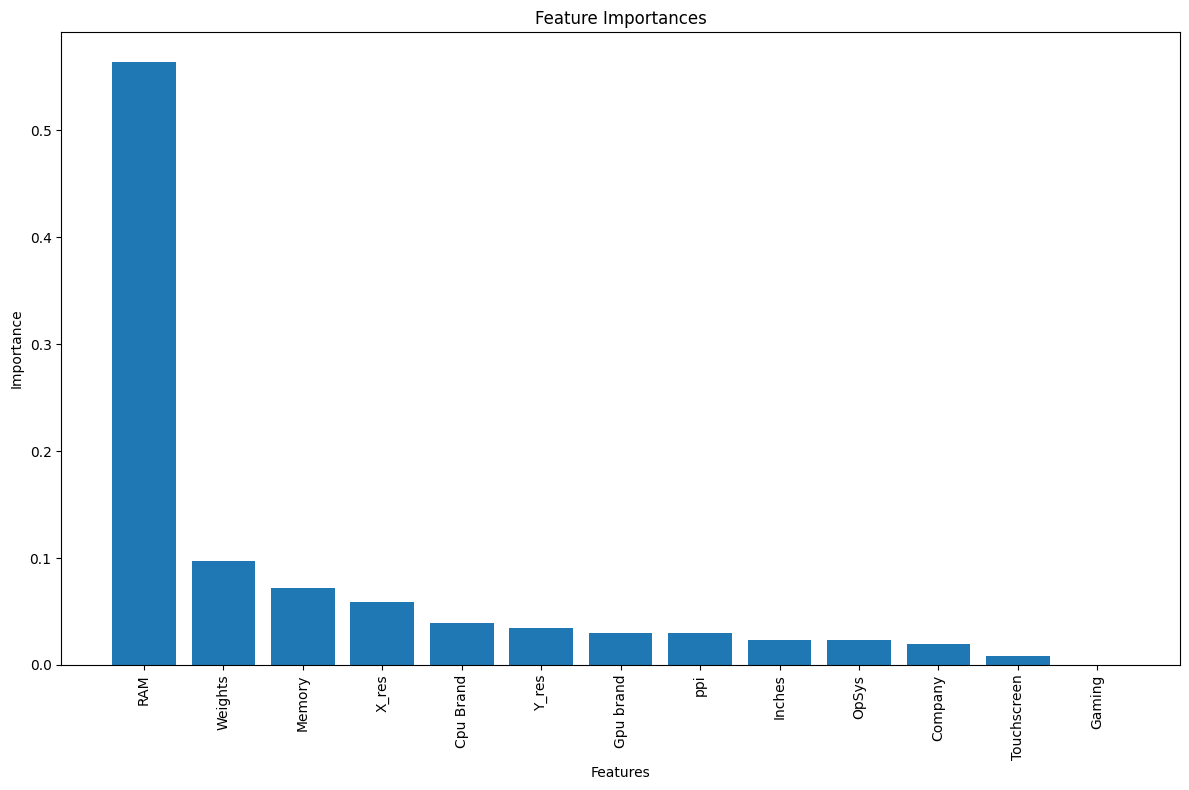

In [104]:
plt.figure(figsize=(12, 8))
plt.bar(feature_importances3.index, feature_importances3['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Thử với thuật toán GradientBoosting trên tập big

In [105]:
rf = GradientBoostingRegressor(random_state=3)

rf.fit(X_train_b, y_train_b)

feature_importances4 = pd.DataFrame(rf.feature_importances_, index=X_train_b.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances4)

top_features4 = feature_importances4.index[:6].tolist()
print(top_features4)

             importance
RAM            0.473370
Memory         0.188105
Y_res          0.092113
Cpu Brand      0.073677
Gpu brand      0.042783
Weights        0.036457
Inches         0.027333
X_res          0.023196
OpSys          0.022101
Company        0.008698
ppi            0.006412
Touchscreen    0.005410
Gaming         0.000345
['RAM', 'Memory', 'Y_res', 'Cpu Brand', 'Gpu brand', 'Weights']


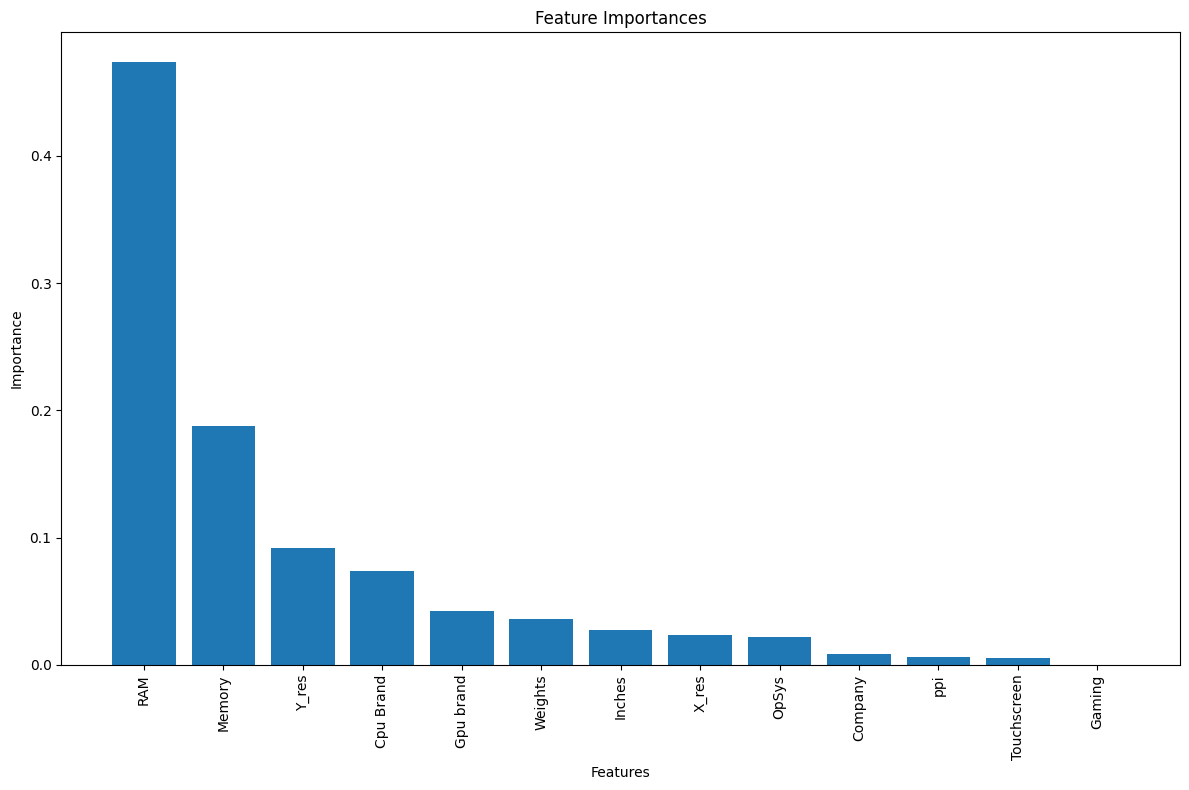

In [106]:
plt.figure(figsize=(12, 8))
plt.bar(feature_importances4.index, feature_importances4['importance'])
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Thử dự dùng kĩ thuật cross_validate để đánh giá việc lựa chọn đặc trưng

In [261]:
Selecting_rs = pd.DataFrame(columns=['Case','Big data', 'Small data'])

model = RandomForestRegressor(random_state=3)

result_small = cross_validate(model, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(model, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Case': 'Randomforest before selecting feature','Big data':average_r2_b, 'Small data': average_r2_s}
Selecting_rs = pd.concat([Selecting_rs, pd.DataFrame([row])], ignore_index=True)

In [262]:
model = RandomForestRegressor(random_state=3)
X_big_temp = X_big[['RAM', 'Memory', 'Weights', 'Cpu Brand', 'Y_res', 'Company']]
X_small_temp = X_small[['RAM', 'Weights', 'Memory', 'Cpu Brand', 'Company', 'ppi']]
result_small = cross_validate(model, X_small_temp, y_small, cv=5, scoring='r2')
result_big = cross_validate(model, X_big_temp, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Case': 'Randomforest after selecting feature','Big data':average_r2_b, 'Small data': average_r2_s}
Selecting_rs = pd.concat([Selecting_rs, pd.DataFrame([row])], ignore_index=True)

In [263]:
model = GradientBoostingRegressor(random_state=3)

result_small = cross_validate(model, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(model, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Case': 'GradientBoostingRegressor before selecting feature','Big data':average_r2_b, 'Small data': average_r2_s}
Selecting_rs = pd.concat([Selecting_rs, pd.DataFrame([row])], ignore_index=True)

In [264]:
model = GradientBoostingRegressor(random_state=3)
X_big_temp = X_big[['RAM', 'Memory', 'Y_res', 'Cpu Brand', 'Gpu brand', 'Weights']]
X_small_temp = X_small[['RAM', 'Weights', 'Memory', 'X_res', 'Y_res', 'Cpu Brand']]
result_small = cross_validate(model, X_small_temp, y_small, cv=5, scoring='r2')
result_big = cross_validate(model, X_big_temp, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Case': 'GradientBoostingRegressor after selecting feature','Big data':average_r2_b, 'Small data': average_r2_s}
Selecting_rs = pd.concat([Selecting_rs, pd.DataFrame([row])], ignore_index=True)

In [265]:
Selecting_rs

,Case,Big data,Small data
0,Randomforest before selecting feature,0.584292,0.509331
1,Randomforest after selecting feature,0.542590,0.495388
2,GradientBoostingRegressor before selecting fea...,0.558587,0.514512
3,GradientBoostingRegressor after selecting feature,0.557933,0.483119


Thử dự đoán tập test dùng selecting feature

In [112]:
result = pd.DataFrame(columns=['Case','R2 score', 'MSE', 'MAE'])
X_train_temp = X_train_b.copy()
rf = RandomForestRegressor(random_state=3)
rf.fit(X_train_temp, y_train_b)
y_pred_test_b = rf.predict(X_test_b)

row = {'Case': 'RandomForest before selecting feature', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)


In [113]:

X_train_temp = X_train_b[['RAM', 'Memory', 'Weights', 'Cpu Brand', 'Y_res', 'Company']]
rf = RandomForestRegressor(random_state=3)
X_test_temp = X_test_b[['RAM', 'Memory', 'Weights', 'Cpu Brand', 'Y_res', 'Company']]
rf.fit(X_train_temp, y_train_b)
y_pred_test_b = rf.predict(X_test_temp)

row = {'Case': 'RandomForest after selecting feature', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [114]:
X_train_temp = X_train_b.copy()
rf = GradientBoostingRegressor(random_state=3)
rf.fit(X_train_temp, y_train_b)
y_pred_test_b = rf.predict(X_test_b)

row = {'Case': 'GradientBoostingRegressor before selecting feature', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [115]:
X_train_temp = X_train_b[['RAM', 'Memory', 'Y_res', 'Cpu Brand', 'Gpu brand', 'Weights']]
rf = GradientBoostingRegressor(random_state=3)
X_test_temp = X_test_b[['RAM', 'Memory', 'Y_res', 'Cpu Brand', 'Gpu brand', 'Weights']]
rf.fit(X_train_temp, y_train_b)
y_pred_test_b = rf.predict(X_test_temp)

row = {'Case': 'GradientBoostingRegressor after selecting feature', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [116]:
result

,Case,R2 score,MSE,MAE
0,RandomForest before selecting feature,0.787109,0.114499,0.197723
1,RandomForest after selecting feature,0.755541,0.131478,0.220920
2,GradientBoostingRegressor before selecting fea...,0.678628,0.172843,0.307257
3,GradientBoostingRegressor after selecting feature,0.665028,0.180158,0.314926


#### Thử nghiệm kĩ thuật chuẩn hóa

Thử trên thuật toán RandomForest

In [118]:
X_big.sample()

,Company,Inches,RAM,Memory,OpSys,Weights,X_res,Y_res,Cpu Brand,Gpu brand,Gaming,Touchscreen,ppi
8786,2,14.0,12.0,256.0,2,3.0,1920.0,1080.0,3,1,0,0,157.350512


In [119]:
Scaling_rs = pd.DataFrame(columns=['Scaling method','Big data', 'Small data'])
scaler = StandardScaler()
model = RandomForestRegressor(random_state=3)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'StandardScaler','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs = pd.concat([Scaling_rs, pd.DataFrame([row])], ignore_index=True)

In [120]:
scaler = MinMaxScaler()
model = RandomForestRegressor(random_state=3)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'MinMaxScaler','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs = pd.concat([Scaling_rs, pd.DataFrame([row])], ignore_index=True)

In [121]:
scaler =  Normalizer()
model = RandomForestRegressor(random_state=3)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'Normalizer','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs = pd.concat([Scaling_rs, pd.DataFrame([row])], ignore_index=True)

In [122]:
scaler = PowerTransformer()
model = RandomForestRegressor(random_state=3)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'PowerTransformer','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs = pd.concat([Scaling_rs, pd.DataFrame([row])], ignore_index=True)

In [123]:
Scaling_rs

,Scaling method,Big data,Small data
0,StandardScaler,0.584135,0.509845
1,MinMaxScaler,0.584091,0.508919
2,Normalizer,0.577543,0.485173
3,PowerTransformer,0.584025,0.508396


Thử dự đoán tập test dùng thêm kĩ thuật chuẩn hóa trên tập test với randomforest

In [175]:
result = pd.DataFrame(columns=['Case','R2 score', 'MSE', 'MAE'])
X_train_temp = X_train_b.copy()
rf = RandomForestRegressor(random_state=3)

rf.fit(X_train_temp, y_train_b)
y_pred_test_b = rf.predict(X_test_b)

row = {'Case': 'Bigdata before scaling', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [176]:
X_train_temp = X_train_b.copy()
scaler = StandardScaler()
model = RandomForestRegressor(random_state=3)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_temp, y_train_b)
y_pred_test_b = pipe.predict(X_test_b)

row = {'Case': 'Bigdata after scaling', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [177]:

X_train_temp = X_train_s.copy()
rf = RandomForestRegressor(random_state=3)

rf.fit(X_train_temp, y_train_s)
y_pred_test_s = rf.predict(X_test_s)

row = {'Case': 'Smalldata before scaling', 'R2 score': r2_score(y_test_s,y_pred_test_s),'MSE': mean_squared_error(y_test_s, y_pred_test_s), 'MAE': mean_absolute_error(y_test_s,y_pred_test_s) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [178]:
X_train_temp = X_train_s.copy()
scaler = StandardScaler()
model = RandomForestRegressor(random_state=3)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_temp, y_train_s)
y_pred_test_s = pipe.predict(X_test_s)

row = {'Case': 'Smalldata after scaling', 'R2 score': r2_score(y_test_s,y_pred_test_s),'MSE': mean_squared_error(y_test_s, y_pred_test_s), 'MAE': mean_absolute_error(y_test_s,y_pred_test_s) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [179]:
result

,Case,R2 score,MSE,MAE
0,Bigdata before scaling,0.787109,0.114499,0.197723
1,Bigdata after scaling,0.786537,0.114807,0.197880
2,Smalldata before scaling,0.471769,0.361555,0.389582
3,Smalldata after scaling,0.470403,0.362490,0.390665


Thử các phép chuẩn hóa trên thuật toán GradientBoosting

In [129]:
Scaling_rs2 = pd.DataFrame(columns=['Scaling method','Big data', 'Small data'])
scaler = StandardScaler()
model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'StandardScaler','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs2 = pd.concat([Scaling_rs2, pd.DataFrame([row])], ignore_index=True)

In [130]:

scaler = MinMaxScaler()

model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'MinMaxScaler','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs2 = pd.concat([Scaling_rs2, pd.DataFrame([row])], ignore_index=True)

In [131]:
scaler = Normalizer()

model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'Normalizer','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs2 = pd.concat([Scaling_rs2, pd.DataFrame([row])], ignore_index=True)

In [132]:
scaler = PowerTransformer()

model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

result_small = cross_validate(pipe, X_small, y_small, cv=5, scoring='r2')
result_big = cross_validate(pipe, X_big, y_big, cv=5, scoring='r2')

average_r2_s = np.mean(result_small['test_score'])
average_r2_b = np.mean(result_big['test_score'])
row = {'Scaling method': 'PowerTransformer','Big data':average_r2_b, 'Small data': average_r2_s}
Scaling_rs2 = pd.concat([Scaling_rs2, pd.DataFrame([row])], ignore_index=True)

In [133]:
Scaling_rs2

,Scaling method,Big data,Small data
0,StandardScaler,0.558623,0.514466
1,MinMaxScaler,0.558617,0.512352
2,Normalizer,0.547278,0.510476
3,PowerTransformer,0.558611,0.513576


Dự đoán dùng thêm kĩ thuật chuẩn hóa với GradientBoostingRegressor

In [134]:
result = pd.DataFrame(columns=['Case','R2 score', 'MSE', 'MAE'])
X_train_temp = X_train_b.copy()
rf = GradientBoostingRegressor(random_state=3)

rf.fit(X_train_temp, y_train_b)
y_pred_test_b = rf.predict(X_test_b)

row = {'Case': 'Bigdata before scaling', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [135]:
X_train_temp = X_train_b.copy()
scaler = StandardScaler()
model = GradientBoostingRegressor(random_state=3)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_temp, y_train_b)
y_pred_test_b = pipe.predict(X_test_b)

row = {'Case': 'Bigdata after scaling', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [136]:

X_train_temp = X_train_s.copy()
rf = GradientBoostingRegressor(random_state=3)

rf.fit(X_train_temp, y_train_s)
y_pred_test_s = rf.predict(X_test_s)

row = {'Case': 'Smalldata before scaling', 'R2 score': r2_score(y_test_s,y_pred_test_s),'MSE': mean_squared_error(y_test_s, y_pred_test_s), 'MAE': mean_absolute_error(y_test_s,y_pred_test_s) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [137]:
X_train_temp = X_train_s.copy()
scaler = StandardScaler()
model = GradientBoostingRegressor(random_state=3)
pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_temp, y_train_s)
y_pred_test_s = pipe.predict(X_test_s)

row = {'Case': 'Smalldata after scaling', 'R2 score': r2_score(y_test_s,y_pred_test_s),'MSE': mean_squared_error(y_test_s, y_pred_test_s), 'MAE': mean_absolute_error(y_test_s,y_pred_test_s) }
result = pd.concat([result, pd.DataFrame([row])], ignore_index=True)

In [139]:
result

,Case,R2 score,MSE,MAE
0,Bigdata before scaling,0.678628,0.172843,0.307257
1,Bigdata after scaling,0.678643,0.172835,0.307232
2,Smalldata before scaling,0.457505,0.371318,0.395150
3,Bigdata after scaling,0.455376,0.372775,0.396115


In [204]:
X_big.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10305 entries, 0 to 10304
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Company      10305 non-null  int32  
 1   Inches       10305 non-null  float64
 2   RAM          10305 non-null  float64
 3   Memory       10305 non-null  float64
 4   OpSys        10305 non-null  int32  
 5   Weights      10305 non-null  float64
 6   X_res        10305 non-null  float64
 7   Y_res        10305 non-null  float64
 8   Cpu Brand    10305 non-null  int32  
 9   Gpu brand    10305 non-null  int32  
 10  Gaming       10305 non-null  int32  
 11  Touchscreen  10305 non-null  int32  
 12  ppi          10305 non-null  float64
dtypes: float64(7), int32(6)
memory usage: 805.2 KB


In [203]:
y_big

0        5.521421
1        5.991440
2        5.135740
3        6.871015
4        7.549604
           ...   
10300    6.214588
10301    6.272858
10302    6.936333
10303    6.523548
10304    6.960338
Name: Price, Length: 10305, dtype: float64

Ram và memory trước và sau khi chuẩn hóa

In [221]:
X_big_temp = X_big.copy()
X_scaled = X_big.copy()
ram_threshold = 150  
memory_threshold = 3000 

# Loại bỏ giá trị quá lớn và thay thế bằng 0
X_scaled['RAM'] = X_scaled['RAM'].clip(upper=ram_threshold)
X_scaled['Memory'] = X_scaled['Memory'].clip(upper=memory_threshold)

X_big_temp['RAM'] = X_big_temp['RAM'].clip(upper=ram_threshold)
X_big_temp['Memory'] = X_big_temp['Memory'].clip(upper=memory_threshold)

scaler = StandardScaler()
X_scaled[['RAM', 'Memory']] = scaler.fit_transform(X_scaled[['RAM', 'Memory']])

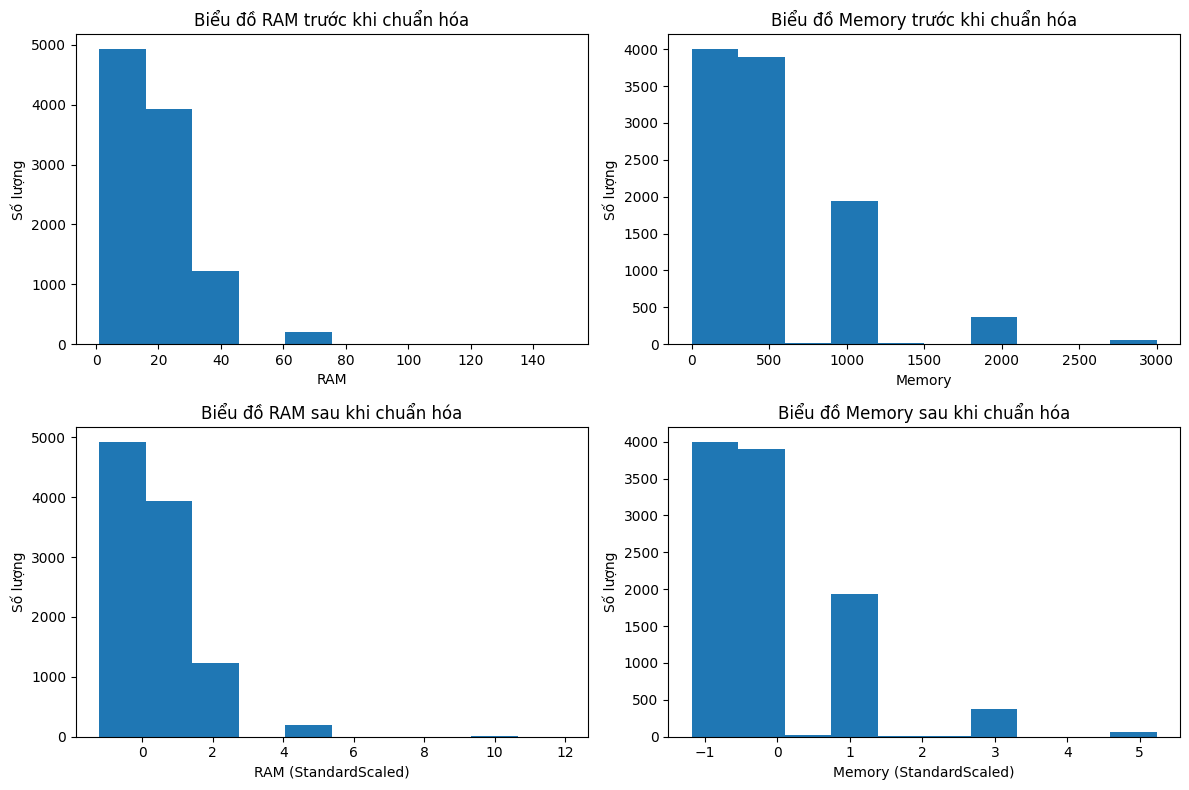

In [222]:


# Vẽ biểu đồ trước khi chuẩn hóa
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Biểu đồ RAM trước khi chuẩn hóa
axes[0, 0].hist(X_big_temp['RAM'], bins=10)
axes[0, 0].set_xlabel('RAM')
axes[0, 0].set_ylabel('Số lượng')
axes[0, 0].set_title('Biểu đồ RAM trước khi chuẩn hóa')

# Biểu đồ Memory trước khi chuẩn hóa
axes[0, 1].hist(X_big_temp['Memory'], bins=10)
axes[0, 1].set_xlabel('Memory')
axes[0, 1].set_ylabel('Số lượng')
axes[0, 1].set_title('Biểu đồ Memory trước khi chuẩn hóa')

# Biểu đồ RAM sau khi chuẩn hóa
axes[1, 0].hist(X_scaled['RAM'], bins=10)
axes[1, 0].set_xlabel('RAM (StandardScaled)')
axes[1, 0].set_ylabel('Số lượng')
axes[1, 0].set_title('Biểu đồ RAM sau khi chuẩn hóa')

# Biểu đồ Memory sau khi chuẩn hóa
axes[1, 1].hist(X_scaled['Memory'], bins=10)
axes[1, 1].set_xlabel('Memory (StandardScaled)')
axes[1, 1].set_ylabel('Số lượng')
axes[1, 1].set_title('Biểu đồ Memory sau khi chuẩn hóa')

plt.tight_layout()
plt.show()


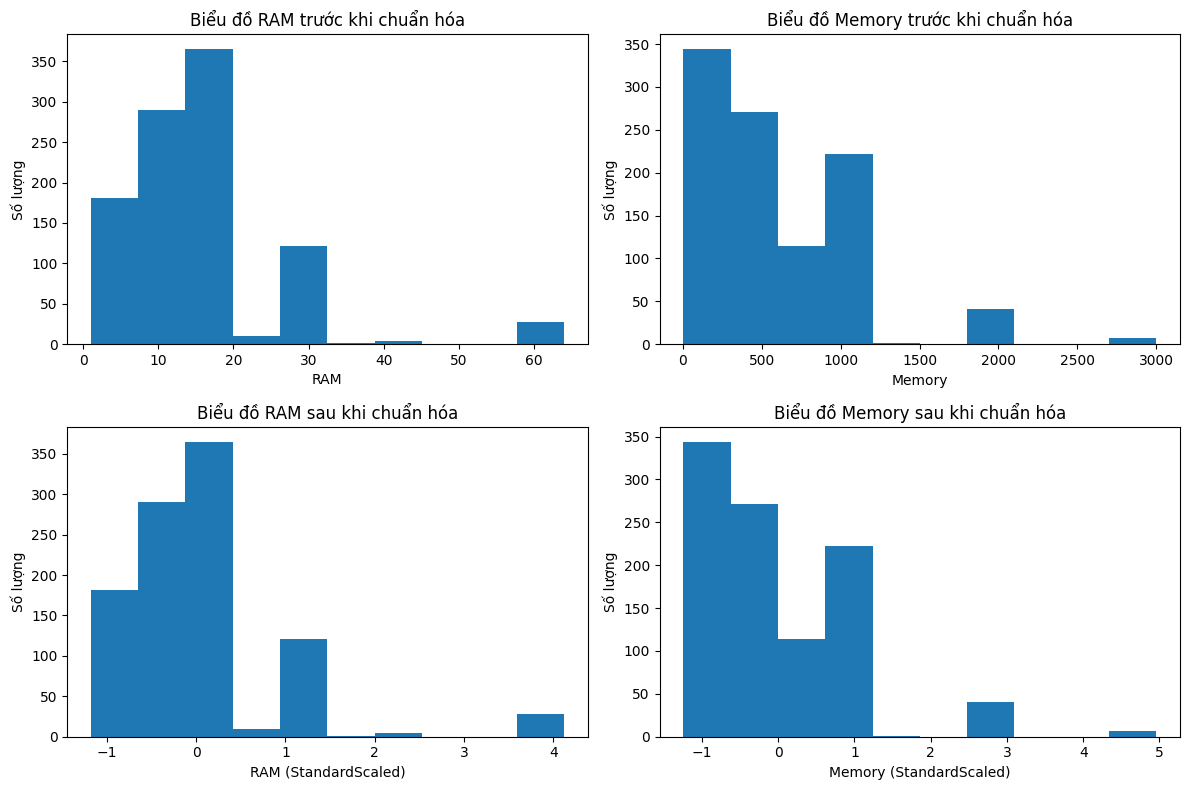

In [223]:
X_small_temp = X_small.copy()
X_scaled = X_small.copy()
ram_threshold = 150  
memory_threshold = 3000 

# Loại bỏ giá trị quá lớn và thay thế bằng 0
X_scaled['RAM'] = X_scaled['RAM'].clip(upper=ram_threshold)
X_scaled['Memory'] = X_scaled['Memory'].clip(upper=memory_threshold)

X_small_temp['RAM'] = X_small_temp['RAM'].clip(upper=ram_threshold)
X_small_temp['Memory'] = X_small_temp['Memory'].clip(upper=memory_threshold)

scaler = StandardScaler()
X_scaled[['RAM', 'Memory']] = scaler.fit_transform(X_scaled[['RAM', 'Memory']])

# Vẽ biểu đồ trước khi chuẩn hóa
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))

# Biểu đồ RAM trước khi chuẩn hóa
axes[0, 0].hist(X_small_temp['RAM'], bins=10)
axes[0, 0].set_xlabel('RAM')
axes[0, 0].set_ylabel('Số lượng')
axes[0, 0].set_title('Biểu đồ RAM trước khi chuẩn hóa')

# Biểu đồ Memory trước khi chuẩn hóa
axes[0, 1].hist(X_small_temp['Memory'], bins=10)
axes[0, 1].set_xlabel('Memory')
axes[0, 1].set_ylabel('Số lượng')
axes[0, 1].set_title('Biểu đồ Memory trước khi chuẩn hóa')

# Biểu đồ RAM sau khi chuẩn hóa
axes[1, 0].hist(X_scaled['RAM'], bins=10)
axes[1, 0].set_xlabel('RAM (StandardScaled)')
axes[1, 0].set_ylabel('Số lượng')
axes[1, 0].set_title('Biểu đồ RAM sau khi chuẩn hóa')

# Biểu đồ Memory sau khi chuẩn hóa
axes[1, 1].hist(X_scaled['Memory'], bins=10)
axes[1, 1].set_xlabel('Memory (StandardScaled)')
axes[1, 1].set_ylabel('Số lượng')
axes[1, 1].set_title('Biểu đồ Memory sau khi chuẩn hóa')

plt.tight_layout()
plt.show()

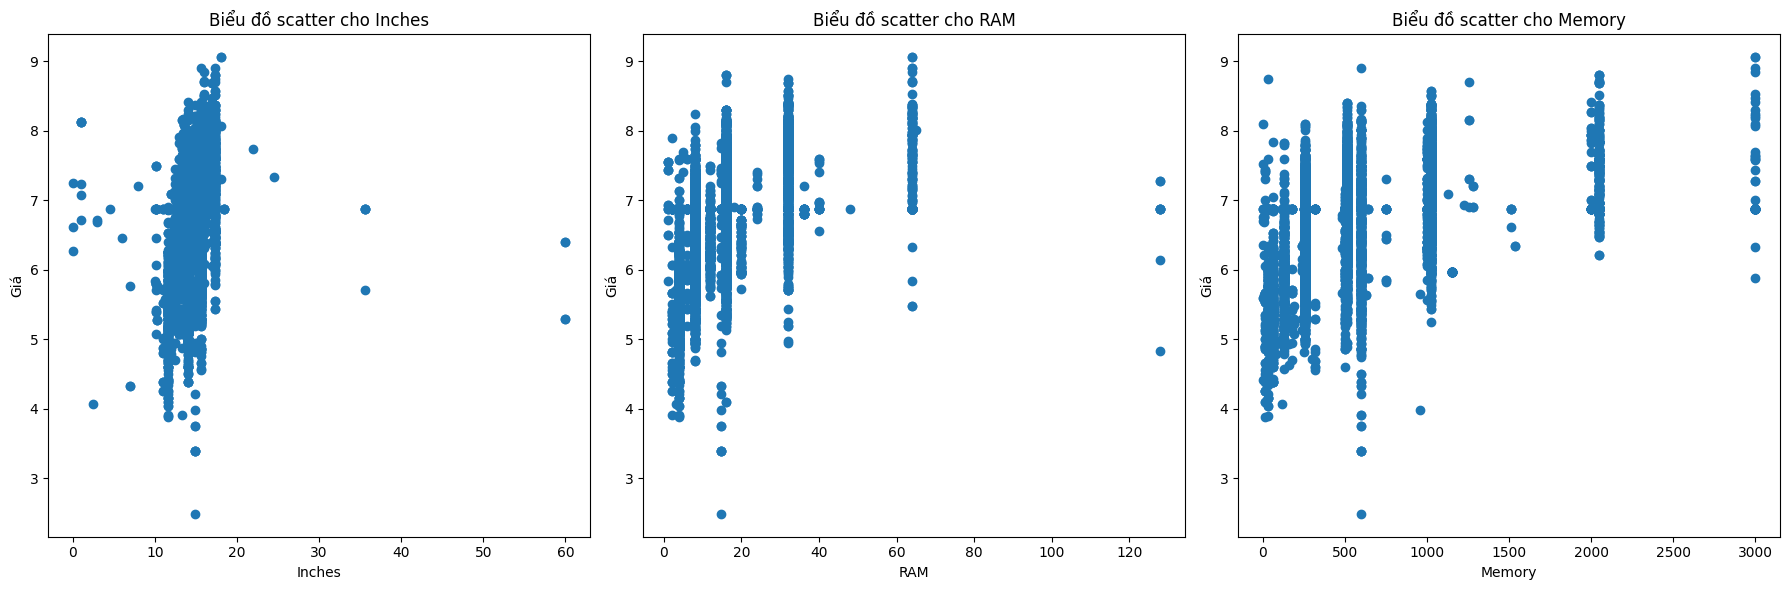

In [228]:
# Giả sử các đặc trưng cụ thể là 'Inches', 'RAM', 'Memory'
X_features = X_big[['Inches', 'RAM', 'Memory']]

# Thiết lập ngưỡng
ram_threshold = 128  
memory_threshold = 3000 
inches_threshold = 60 

# Loại bỏ giá trị quá lớn và thay thế bằng 0
X_features['RAM'] = X_features['RAM'].clip(upper=ram_threshold)
X_features['Memory'] = X_features['Memory'].clip(upper=memory_threshold)
X_features['Inches'] = X_features['Inches'].clip(upper=inches_threshold)
# Vẽ biểu đồ scatter
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, feature in enumerate(X_features.columns):
    axes[i].scatter(X_features[feature], y_big)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Giá')
    axes[i].set_title(f'Biểu đồ scatter cho {feature}')

plt.tight_layout()
plt.show()

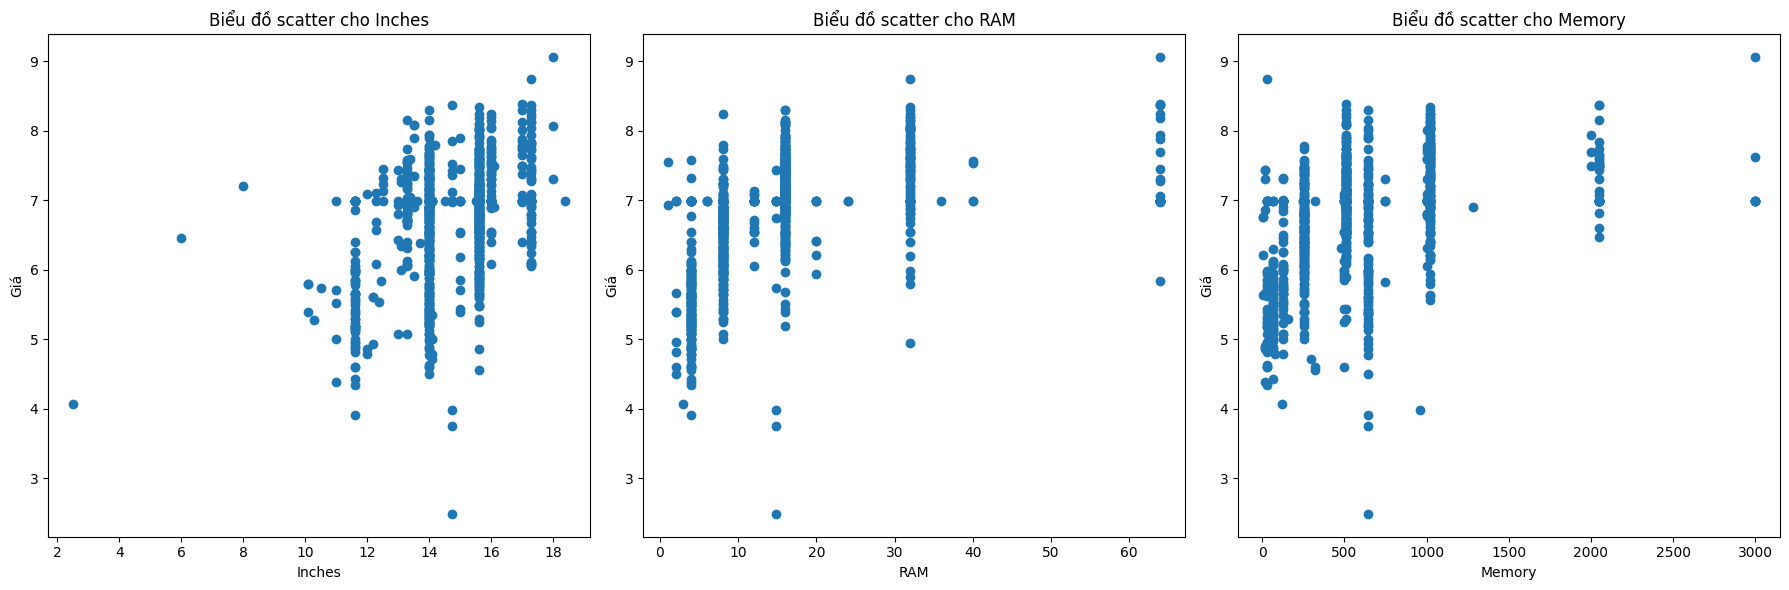

In [229]:
# Giả sử các đặc trưng cụ thể là 'Inches', 'RAM', 'Memory'
X_features = X_small[['Inches', 'RAM', 'Memory']]

# Thiết lập ngưỡng
ram_threshold = 128  # Giá trị ngưỡng cho cột 'RAM'
memory_threshold = 3000  # Giá trị ngưỡng cho cột 'Memory'
inches_threshold = 60 

# Loại bỏ giá trị quá lớn và thay thế bằng 0
X_features['RAM'] = X_features['RAM'].clip(upper=ram_threshold)
X_features['Memory'] = X_features['Memory'].clip(upper=memory_threshold)
X_features['Inches'] = X_features['Inches'].clip(upper=inches_threshold)
# Vẽ biểu đồ scatter
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

for i, feature in enumerate(X_features.columns):
    axes[i].scatter(X_features[feature], y_small)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Giá')
    axes[i].set_title(f'Biểu đồ scatter cho {feature}')

plt.tight_layout()
plt.show()

Trực quan hóa trên không gian đặc trưng với tập big data

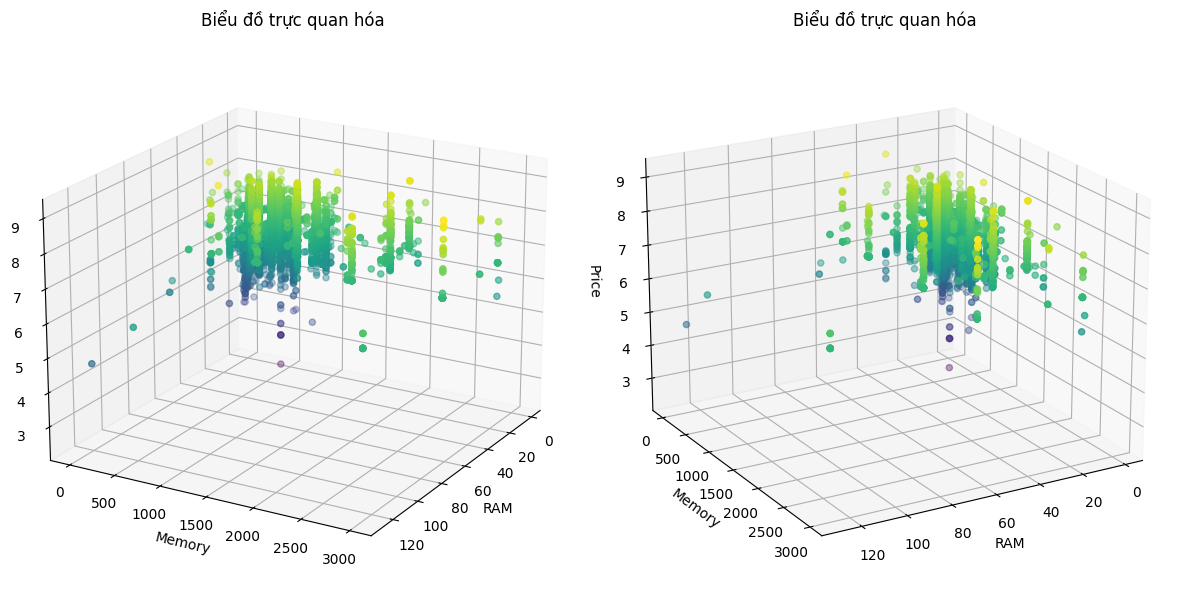

In [254]:
from mpl_toolkits.mplot3d import Axes3D

# Tạo hai đối tượng subplot 3D
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ram_threshold = 128  
memory_threshold = 3000  
inches_threshold = 60 
ram = X_big['RAM'].clip(upper=ram_threshold)
memory = X_big['Memory'].clip(upper=memory_threshold)
price = y_big


scatter1 = ax1.scatter(ram, memory, price, c=price, cmap='viridis')
ax1.set_xlabel('RAM')
ax1.set_ylabel('Memory')
ax1.set_zlabel('Price')
ax1.set_title('Biểu đồ trực quan hóa')

scatter2 = ax2.scatter(ram, memory, price, c=price, cmap='viridis')
ax2.set_xlabel('RAM')
ax2.set_ylabel('Memory')
ax2.set_zlabel('Price')
ax2.set_title('Biểu đồ trực quan hóa')

# Thiết lập góc nhìn cho biểu đồ thứ nhất
ax1.view_init(elev=20, azim=30)

# Thiết lập góc nhìn cho biểu đồ thứ hai
ax2.view_init(elev=20, azim=60)



plt.tight_layout()
plt.show()


Trực quan hóa trên không gian đặc trưng với small data

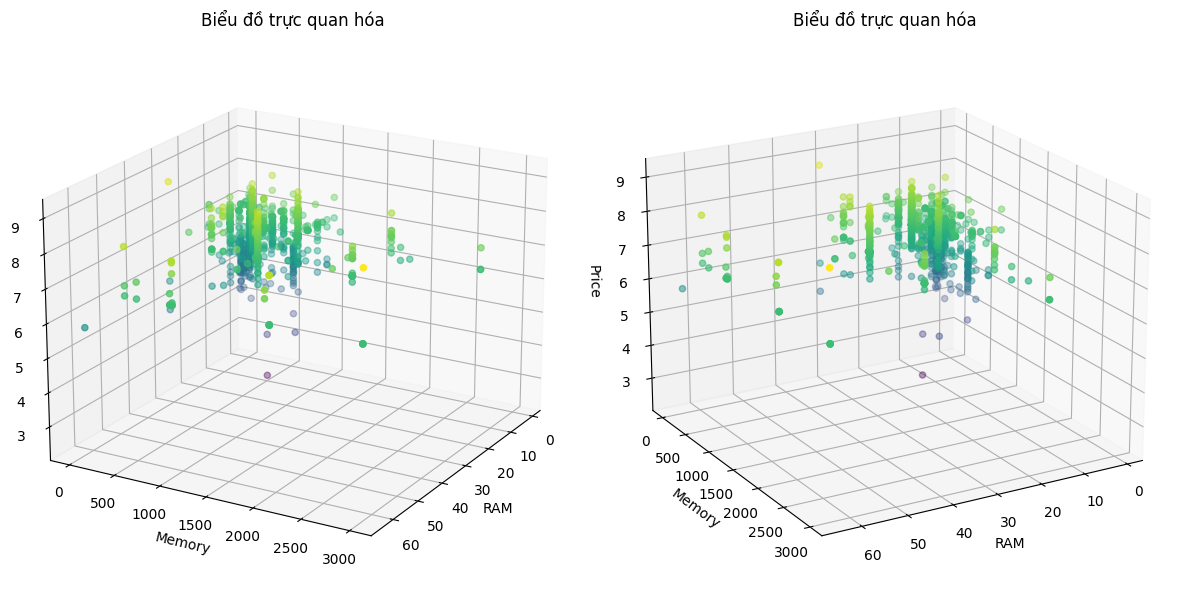

In [256]:
from mpl_toolkits.mplot3d import Axes3D

# Tạo hai đối tượng subplot 3D
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ram_threshold = 128  
memory_threshold = 3000  
inches_threshold = 60 
ram = X_small['RAM'].clip(upper=ram_threshold)
memory = X_small['Memory'].clip(upper=memory_threshold)
price = y_small


scatter1 = ax1.scatter(ram, memory, price, c=price, cmap='viridis')
ax1.set_xlabel('RAM')
ax1.set_ylabel('Memory')
ax1.set_zlabel('Price')
ax1.set_title('Biểu đồ trực quan hóa')

scatter2 = ax2.scatter(ram, memory, price, c=price, cmap='viridis')
ax2.set_xlabel('RAM')
ax2.set_ylabel('Memory')
ax2.set_zlabel('Price')
ax2.set_title('Biểu đồ trực quan hóa')

# Thiết lập góc nhìn cho biểu đồ thứ nhất
ax1.view_init(elev=20, azim=30)

# Thiết lập góc nhìn cho biểu đồ thứ hai
ax2.view_init(elev=20, azim=60)



plt.tight_layout()
plt.show()


#### Tìm bộ tham số tối ưu cho mô hình randomforest

In [148]:
from sklearn.model_selection import GridSearchCV

In [160]:
Find_parameter_rs = pd.DataFrame(columns=['Case','R2 score', 'MSE', 'MAE'])
scaler = StandardScaler()
model = RandomForestRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_b, y_train_b)
y_pred_test_b = pipe.predict(X_test_b)
# y_pred_val_b = pipe.predict(X_val_b)
row = {'Case': 'Test before using best parameter', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }

Find_parameter_rs = pd.concat([Find_parameter_rs, pd.DataFrame([row])], ignore_index=True)

In [153]:

param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [10, 15, 20],
    'model__max_samples': [0.5, 0.6, 0.7],
    'model__max_features': [0.5, 0.75, 1.0]
}

scaler = StandardScaler()
model = RandomForestRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_b, y_train_b)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=3))]),
             param_grid={'model__max_depth': [10, 15, 20],
                         'model__max_features': [0.5, 0.75, 1.0],
                         'model__max_samples': [0.5, 0.6, 0.7],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [154]:

best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'model__max_depth': 20, 'model__max_features': 0.5, 'model__max_samples': 0.7, 'model__n_estimators': 300}


In [161]:
scaler =  StandardScaler()
model = RandomForestRegressor(n_estimators=300,
                              random_state=3,
                              max_samples=0.7,
                              max_features=0.5,
                              max_depth=20)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_b, y_train_b)
# y_pred_val = pipe.predict(X_val_b)
y_pred_test_b = pipe.predict(X_test_b)

row = {'Case': 'Test after using best parameter', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }

Find_parameter_rs = pd.concat([Find_parameter_rs, pd.DataFrame([row])], ignore_index=True)


In [162]:
scaler = StandardScaler()
model = RandomForestRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_b, y_train_b)
y_pred_val_b = pipe.predict(X_val_b)
# y_pred_val_b = pipe.predict(X_val_b)
row = {'Case': 'Val before using best parameter', 'R2 score': r2_score(y_val_b,y_pred_val_b),'MSE': mean_squared_error(y_val_b, y_pred_val_b), 'MAE': mean_absolute_error(y_val_b,y_pred_val_b) }

Find_parameter_rs = pd.concat([Find_parameter_rs, pd.DataFrame([row])], ignore_index=True)

In [164]:
scaler =  StandardScaler()
model = RandomForestRegressor(n_estimators=300,
                              random_state=3,
                              max_samples=0.7,
                              max_features=0.5,
                              max_depth=20)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_b, y_train_b)
y_pred_val_b = pipe.predict(X_val_b)

row = {'Case': 'Val after using best parameter', 'R2 score': r2_score(y_val_b,y_pred_val_b),'MSE': mean_squared_error(y_val_b, y_pred_val_b), 'MAE': mean_absolute_error(y_val_b,y_pred_val_b) }

Find_parameter_rs = pd.concat([Find_parameter_rs, pd.DataFrame([row])], ignore_index=True)

In [165]:
Find_parameter_rs

,Case,R2 score,MSE,MAE
0,Test before using best parameter,0.786537,0.114807,0.197880
1,Test after using best parameter,0.779080,0.118817,0.211935
2,Val before using best parameter,0.783945,0.128418,0.217694
3,Val after using best parameter,0.785169,0.127691,0.228312


Thử mô hình tối ưu trên tập small

In [166]:
pipe.fit(X_train_s, y_train_s)
y_pred_val_s = pipe.predict(X_val_s)
y_pred_test_s = pipe.predict(X_test_s)


print("R2 score on test set:", r2_score(y_test_s,y_pred_test_s))

print("R2 score on validation set:", r2_score(y_val_s,y_pred_val_s))

print('Mean Squared Error test:', mean_squared_error(y_test_s, y_pred_test_s))

print('Mean Squared Error validation:', mean_squared_error(y_val_s, y_pred_val_s))

print('MAE test:',mean_absolute_error(y_test_s,y_pred_test_s))

print('MAE val:',mean_absolute_error(y_val_s,y_pred_val_s))

R2 score on test set: 0.476771294386646
R2 score on validation set: 0.5326433250183065
Mean Squared Error test: 0.35813072338091834
Mean Squared Error validation: 0.31518629250815977
MAE test: 0.39044596768736084
MAE val: 0.4240420858030368


#### Tìm lại bộ tham số tối ưu cho tập small

In [167]:
X_train_s.sample(10)

,Company,Inches,RAM,Memory,OpSys,Weights,X_res,Y_res,Cpu Brand,Gpu brand,Gaming,Touchscreen,ppi
495,0,14.0,8.0,256.000000,2,2.640000,1920.000000,1080.000000,5,1,0,0,157.350512
613,5,14.0,16.0,1024.000000,2,4.200000,1920.000000,1080.000000,6,2,0,0,157.350512
416,4,14.0,4.0,64.000000,2,4.510000,1366.000000,768.000000,5,1,0,0,111.935204
689,4,14.0,4.0,128.000000,2,3.250000,1366.000000,768.000000,1,0,0,0,111.935204
2,3,14.0,12.0,512.000000,2,7.000000,1920.000000,1080.000000,4,1,0,0,157.350512
313,7,12.2,4.0,639.411576,0,2.910000,1920.000000,1080.000000,5,1,0,0,180.566161
659,5,14.0,16.0,639.411576,2,5.100000,1920.000000,1080.000000,5,1,0,0,157.350512
294,4,15.6,12.0,512.000000,2,4.920000,1920.000000,1080.000000,4,2,1,0,141.211998
348,4,15.6,8.0,256.000000,2,3.750000,1920.000000,1080.000000,4,1,0,0,141.211998
488,4,15.6,16.0,512.000000,1,5.006654,1950.222962,1122.838261,0,1,0,1,144.254063


In [170]:
Find_parameter_rs2 = pd.DataFrame(columns=['Case','R2 score', 'MSE', 'MAE'])
scaler = StandardScaler()
model = RandomForestRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_s, y_train_s)
y_pred_test_s = pipe.predict(X_test_s)
# y_pred_val_b = pipe.predict(X_val_b)
row = {'Case': 'Test before using best parameter', 'R2 score': r2_score(y_test_s,y_pred_test_s),'MSE': mean_squared_error(y_test_s, y_pred_test_s), 'MAE': mean_absolute_error(y_test_s,y_pred_test_s) }

Find_parameter_rs2 = pd.concat([Find_parameter_rs2, pd.DataFrame([row])], ignore_index=True)

In [168]:

param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [10, 15, 20],
    'model__max_samples': [0.5, 0.6, 0.7],
    'model__max_features': [0.5, 0.75, 1.0]
}

scaler =  StandardScaler()
model = RandomForestRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

# Tìm kiếm siêu tham số tối ưu
grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(random_state=3))]),
             param_grid={'model__max_depth': [10, 15, 20],
                         'model__max_features': [0.5, 0.75, 1.0],
                         'model__max_samples': [0.5, 0.6, 0.7],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [169]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'model__max_depth': 15, 'model__max_features': 0.5, 'model__max_samples': 0.5, 'model__n_estimators': 100}


In [171]:
scaler  =  StandardScaler()
model = RandomForestRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=0.5,
                              max_features=0.5,
                              max_depth=15)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_s, y_train_s)
y_pred_test_s = pipe.predict(X_test_s)


row = {'Case': 'Test after using best parameter', 'R2 score': r2_score(y_test_s,y_pred_test_s),'MSE': mean_squared_error(y_test_s, y_pred_test_s), 'MAE': mean_absolute_error(y_test_s,y_pred_test_s) }

Find_parameter_rs2 = pd.concat([Find_parameter_rs2, pd.DataFrame([row])], ignore_index=True)

In [172]:
scaler = StandardScaler()
model = RandomForestRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_s, y_train_s)
y_pred_val_s = pipe.predict(X_val_s)

row = {'Case': 'Val before using best parameter', 'R2 score': r2_score(y_val_s,y_pred_val_s),'MSE': mean_squared_error(y_val_s, y_pred_val_s), 'MAE': mean_absolute_error(y_val_s,y_pred_val_s) }

Find_parameter_rs2 = pd.concat([Find_parameter_rs2, pd.DataFrame([row])], ignore_index=True)

In [173]:
scaler = StandardScaler()
model = RandomForestRegressor(n_estimators=100,
                              random_state=3,
                              max_samples=0.5,
                              max_features=0.5,
                              max_depth=15)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_s, y_train_s)
y_pred_val_s = pipe.predict(X_val_s)

row = {'Case': 'Val after using best parameter', 'R2 score': r2_score(y_val_s,y_pred_val_s),'MSE': mean_squared_error(y_val_s, y_pred_val_s), 'MAE': mean_absolute_error(y_val_s,y_pred_val_s) }

Find_parameter_rs2 = pd.concat([Find_parameter_rs2, pd.DataFrame([row])], ignore_index=True)

In [174]:
Find_parameter_rs2

,Case,R2 score,MSE,MAE
0,Test before using best parameter,0.470403,0.362490,0.390665
1,Test after using best parameter,0.494632,0.345906,0.386990
2,Val before using best parameter,0.513457,0.328125,0.430067
3,Val after using best parameter,0.538512,0.311228,0.418905


### Tìm bộ tham số tối ưu cho mô hình GradientBoosting

Thử dự đoán bằng default parameter

In [187]:
Find_parameter_rs = pd.DataFrame(columns=['Case','R2 score', 'MSE', 'MAE'])
scaler = StandardScaler()
model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_b, y_train_b)
y_pred_test_b = pipe.predict(X_test_b)

row = {'Case': 'Test before using best parameter', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }

Find_parameter_rs = pd.concat([Find_parameter_rs, pd.DataFrame([row])], ignore_index=True)

#### Tìm tham số tối ưu bằng gridsearchCV trên tập lớn

In [181]:
import warnings
warnings.filterwarnings('ignore')
param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

scaler = StandardScaler()

model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])


grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_b, y_train_b)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        GradientBoostingRegressor(random_state=3))]),
             param_grid={'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [182]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__max_features': 'auto', 'model__n_estimators': 300}


In [188]:
scaler =  StandardScaler()
model = GradientBoostingRegressor(n_estimators = 300, random_state=3, learning_rate = 0.1, max_depth = 6, max_features = 'auto')

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_b, y_train_b)

y_pred_test_b = pipe.predict(X_test_b)

row = {'Case': 'Test after using best parameter', 'R2 score': r2_score(y_test_b,y_pred_test_b),'MSE': mean_squared_error(y_test_b, y_pred_test_b), 'MAE': mean_absolute_error(y_test_b,y_pred_test_b) }

Find_parameter_rs = pd.concat([Find_parameter_rs, pd.DataFrame([row])], ignore_index=True)


In [189]:
scaler = StandardScaler()
model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_b, y_train_b)
y_pred_val_b = pipe.predict(X_val_b)

row = {'Case': 'val before using best parameter', 'R2 score': r2_score(y_val_b,y_pred_val_b),'MSE': mean_squared_error(y_val_b, y_pred_val_b), 'MAE': mean_absolute_error(y_val_b,y_pred_val_b) }

Find_parameter_rs = pd.concat([Find_parameter_rs, pd.DataFrame([row])], ignore_index=True)

In [190]:
scaler = StandardScaler()
model = GradientBoostingRegressor(n_estimators = 300, random_state=3, learning_rate = 0.1, max_depth = 6, max_features = 'auto')


pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_b, y_train_b)
y_pred_val_b = pipe.predict(X_val_b)

row = {'Case': 'val after using best parameter', 'R2 score': r2_score(y_val_b,y_pred_val_b),'MSE': mean_squared_error(y_val_b, y_pred_val_b), 'MAE': mean_absolute_error(y_val_b,y_pred_val_b) }

Find_parameter_rs = pd.concat([Find_parameter_rs, pd.DataFrame([row])], ignore_index=True)

In [191]:
Find_parameter_rs

,Case,R2 score,MSE,MAE
0,Test before using best parameter,0.678643,0.172835,0.307232
1,Test after using best parameter,0.758442,0.129917,0.232885
2,val before using best parameter,0.667703,0.197510,0.324453
3,val after using best parameter,0.766664,0.138689,0.242427


##### Thử tìm tham số tối ưu cho GradientBoostingRegressor trên tập small 

In [192]:
Find_parameter_rs2 = pd.DataFrame(columns=['Case','R2 score', 'MSE', 'MAE'])
scaler = StandardScaler()
model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_s, y_train_s)
y_pred_test_s = pipe.predict(X_test_s)

row = {'Case': 'Test before using best parameter', 'R2 score': r2_score(y_test_s,y_pred_test_s),'MSE': mean_squared_error(y_test_s, y_pred_test_s), 'MAE': mean_absolute_error(y_test_s,y_pred_test_s) }

Find_parameter_rs2 = pd.concat([Find_parameter_rs2, pd.DataFrame([row])], ignore_index=True)

In [193]:
import warnings
warnings.filterwarnings('ignore')
param_grid = {
    'model__n_estimators': [50, 100, 200, 300],
    'model__max_depth': [3, 4, 5, 6],
    'model__learning_rate': [0.05, 0.1, 0.2],
    'model__max_features': ['auto', 'sqrt', 'log2']
}

scaler = StandardScaler()

model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])


grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_s, y_train_s)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('model',
                                        GradientBoostingRegressor(random_state=3))]),
             param_grid={'model__learning_rate': [0.05, 0.1, 0.2],
                         'model__max_depth': [3, 4, 5, 6],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__n_estimators': [50, 100, 200, 300]},
             scoring='r2')

In [194]:
best_params = grid_search.best_params_
print("Best parameters:", best_params)

Best parameters: {'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__max_features': 'sqrt', 'model__n_estimators': 100}


In [195]:
scaler  =  StandardScaler()
model = GradientBoostingRegressor(n_estimators = 100, random_state=3, learning_rate = 0.05, max_depth = 3, max_features = 'sqrt')

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_s, y_train_s)
y_pred_test_s = pipe.predict(X_test_s)


row = {'Case': 'Test after using best parameter', 'R2 score': r2_score(y_test_s,y_pred_test_s),'MSE': mean_squared_error(y_test_s, y_pred_test_s), 'MAE': mean_absolute_error(y_test_s,y_pred_test_s) }

Find_parameter_rs2 = pd.concat([Find_parameter_rs2, pd.DataFrame([row])], ignore_index=True)

In [196]:
scaler = StandardScaler()
model = GradientBoostingRegressor(random_state=3)

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_s, y_train_s)
y_pred_val_s = pipe.predict(X_val_s)

row = {'Case': 'Val before using best parameter', 'R2 score': r2_score(y_val_s,y_pred_val_s),'MSE': mean_squared_error(y_val_s, y_pred_val_s), 'MAE': mean_absolute_error(y_val_s,y_pred_val_s) }

Find_parameter_rs2 = pd.concat([Find_parameter_rs2, pd.DataFrame([row])], ignore_index=True)

In [197]:
scaler = StandardScaler()
model = GradientBoostingRegressor(n_estimators = 100, random_state=3, learning_rate = 0.05, max_depth = 3, max_features = 'sqrt')


pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_s, y_train_s)
y_pred_val_s = pipe.predict(X_val_s)

row = {'Case': 'Val after using best parameter', 'R2 score': r2_score(y_val_s,y_pred_val_s),'MSE': mean_squared_error(y_val_s, y_pred_val_s), 'MAE': mean_absolute_error(y_val_s,y_pred_val_s) }

Find_parameter_rs2 = pd.concat([Find_parameter_rs2, pd.DataFrame([row])], ignore_index=True)

In [198]:
Find_parameter_rs2

,Case,R2 score,MSE,MAE
0,Test before using best parameter,0.455376,0.372775,0.396115
1,Test after using best parameter,0.487337,0.350899,0.383818
2,Val before using best parameter,0.516648,0.325973,0.425420
3,Val after using best parameter,0.546005,0.306175,0.422085


Thử mô hình trên với tập big

In [199]:
scaler = StandardScaler()
model = GradientBoostingRegressor(n_estimators = 100, random_state=3, learning_rate = 0.05, max_depth = 3, max_features = 'sqrt')

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])
pipe.fit(X_train_b, y_train_b)
y_pred_val_b = pipe.predict(X_val_b)
y_pred_test_b = pipe.predict(X_test_b)


print("R2 score on test set:", r2_score(y_test_b,y_pred_test_b))

print("R2 score on validation set:", r2_score(y_val_b,y_pred_val_b))

print('Mean Squared Error test:', mean_squared_error(y_test_b, y_pred_test_b))

print('Mean Squared Error validation:', mean_squared_error(y_val_b, y_pred_val_b))

print('MAE test:',mean_absolute_error(y_test_b,y_pred_test_b))

print('MAE val:',mean_absolute_error(y_val_b,y_pred_val_b))

R2 score on test set: 0.6561149281116878
R2 score on validation set: 0.6427509136113667
Mean Squared Error test: 0.18495168881667848
Mean Squared Error validation: 0.2123406904329037
MAE test: 0.3224329874239922
MAE val: 0.3428721479111692


Thử nghiệm dự đoán kết hợp 2 mô hình RandomForest và GradientBoosting dùng Votingregressor

In [260]:
from sklearn.ensemble import VotingRegressor,StackingRegressor
from sklearn.pipeline import make_pipeline

scaler = StandardScaler()
rf = RandomForestRegressor(n_estimators=300,
                              random_state=3,
                              max_samples=0.7,
                              max_features=0.5,
                              max_depth=20)
gbdt = GradientBoostingRegressor(n_estimators = 300, random_state=3, learning_rate = 0.1, max_depth = 6, max_features = 'auto')



model = VotingRegressor([('rf', rf), ('gbdt', gbdt)], weights=[3, 1])

pipe = Pipeline([
    ('scale',scaler),
    ('model',model)
])

pipe.fit(X_train_b,y_train_b)

y_pred_test = pipe.predict(X_test_b)
y_pred_val = pipe.predict(X_val_b)

print('R2 score on test: ',r2_score(y_test_b,y_pred_test))
print('MAE on test: ',mean_absolute_error(y_test_b,y_pred_test))
print('Mean Squared Error on test:', mean_squared_error(y_test_b, y_pred_test))

print('R2 score on val: ',r2_score(y_val_b,y_pred_val))
print('MAE on val: ',mean_absolute_error(y_val_b,y_pred_val))
print('Mean Squared Error on val:', mean_squared_error(y_val_b, y_pred_val))


R2 score on test:  0.7825152113315065
MAE on test:  0.2129436061832908
Mean Squared Error on test: 0.1169698316222357
R2 score on val:  0.7878798290209135
MAE on val:  0.22892867899795544
Mean Squared Error on val: 0.12607938068019628


In [266]:
X_big.sample(10)

,Company,Inches,RAM,Memory,OpSys,Weights,X_res,Y_res,Cpu Brand,Gpu brand,Gaming,Touchscreen,ppi
9438,4,15.6,8.0,256.0,2,3.83,1920.000000,1080.000000,5,1,0,0,141.211998
9485,5,14.0,8.0,256.0,2,3.51,1920.000000,1080.000000,4,1,0,0,157.350512
7865,3,15.6,8.0,256.0,2,4.90,1920.000000,1080.000000,3,1,0,0,141.211998
339,0,16.0,32.0,1024.0,2,5.29,2560.000000,1600.000000,6,1,1,0,188.679623
2256,0,11.6,4.0,64.0,0,2.62,1366.000000,768.000000,2,1,0,1,135.094211
2250,2,14.0,4.0,32.0,0,2.95,1920.000000,1080.000000,2,1,0,0,157.350512
6710,3,13.3,8.0,256.0,2,2.60,1920.000000,1080.000000,5,1,0,0,165.632118
10060,5,12.5,8.0,180.0,2,2.00,1995.777946,1147.340407,4,1,0,0,184.165484
4454,5,14.0,16.0,256.0,2,2.50,1920.000000,1200.000000,4,1,0,0,161.725391
3881,0,14.0,8.0,128.0,0,3.42,1366.000000,768.000000,8,1,0,0,111.935204
